## Customer churn prediction using survival analysis

Traditionaly, survival analysis was concerned with studying the time between entry to a study and a subsequent event. Originally, the analysis was concerned with time from treatment until death for patients in a study.
More generally now, we can use survival analysis if we are interested in the time until some event happens.

For our purpose, the importance of such an analysis comes form the fact that, in general, it is more expensive to acquire new customers than to retain existing ones, therefore being able to predict the customers who are more likely to churn can help us allocate marketing costs to these customers which will increase the customer lifetime value.

### Data

We will use [Telco customer churn data](https://www.kaggle.com/blastchar/telco-customer-churn) which  contains information about a fictional telco company.

In [185]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer

In [186]:
df = pd.read_csv('telco_customer_churn.csv')
df_train, df_test = train_test_split(df, random_state=47)

In [187]:
df_train.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
1646,2581-VKIRT,Female,0,Yes,Yes,59,Yes,Yes,DSL,Yes,...,No,Yes,No,No,One year,No,Mailed check,65.50,3801.30,No
5957,6877-LGWXO,Male,1,Yes,No,18,Yes,No,Fiber optic,No,...,No,No,No,Yes,Month-to-month,No,Electronic check,78.55,1422.65,Yes
4527,7666-WKRON,Female,0,No,No,39,Yes,No,Fiber optic,No,...,Yes,Yes,No,No,Two year,Yes,Electronic check,80.45,3201.55,Yes
2191,3988-RQIXO,Female,1,No,No,1,Yes,No,Fiber optic,No,...,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,91.30,91.30,Yes
2017,1087-GRUYI,Male,0,Yes,No,38,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),20.40,743.50,No


### Preprocessing

For survival analysis, we are primarily concerned with the duration of the lifespan which in our case is `tenure` and the observed event which is the `churn` column - whether the customers left or not.

Our dataset contains both numerical and categorical columns. We will scale the numerical ones and one-hot encode the categorical ones.
The `tenure` column will remain unchanged because we want to work with the 'months' unit. The `id` column will be droped in the column transformer since it holds no relevant information.

We'll also replace `yes` and `no` values in the `churn` column to `1` and `0` because the model expects numerical features. In **survival analysis** lingo, the `0` value means the cases are `censored` meaning we don't know when these customers will churn - they are still active customers.

In [188]:
target_column = ['Churn']

In [189]:
drop_features = ['customerID', 'TotalCharges'] # TotalCharges is cumulative and changes overtime
numeric_features = ['tenure', 'MonthlyCharges']
categorical_features = list(set(df_train.columns) - set(numeric_features) - set(drop_features) - set(target_column))

In [190]:
preprocessing = make_column_transformer(
    ('passthrough', ['tenure']),
    (FunctionTransformer(lambda x: x == "Yes"), ['Churn']), # labeling churn column 'yes'==1
    (StandardScaler(), ['MonthlyCharges']),
    (OneHotEncoder(drop='if_binary'), categorical_features)
)

One hot encoding creates new columns, the following lines get the new names.

In [191]:
preprocessing.fit(df_train)
new_cols = ['tenure', 'Churn', 'MonthlyCharges'] + list(preprocessing.named_transformers_['onehotencoder'].get_feature_names_out())

Next, let's transform both data splits.

In [192]:
df_train = pd.DataFrame(preprocessing.transform(df_train), index = df_train.index, columns = new_cols)
df_test = pd.DataFrame(preprocessing.transform(df_test),  index = df_test.index,  columns = new_cols)

In [193]:
df_train.head()

,tenure,Churn,MonthlyCharges,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Partner_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,...,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,Dependents_Yes,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes
1646,59.0,0.0,0.026227,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
5957,18.0,1.0,0.459708,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4527,39.0,1.0,0.522820,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2191,1.0,1.0,0.883224,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2017,38.0,0.0,-1.471858,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


### Survival analysis

In [194]:
import lifelines

We'll grab the *duration* (tenure) and the *censorship* (churn) from our dataframe. We will first plot Kaplan Meier curve which doesn't look at features and plots a survival plot.

In [195]:
T = df_train['tenure'] #duration
C = df_train['Churn'] #censorship

In [196]:
kmf = lifelines.KaplanMeierFitter()
kmf.fit(T, C);

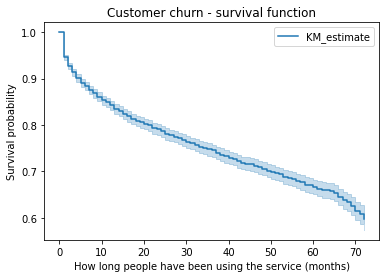

In [197]:
kmf.plot()
plt.title('Customer churn - survival function')
plt.xlabel('How long people have been using the service (months)')
plt.ylabel('Survival probability');

The survival plot tells us what the probability of still being a customer is after a certain amount of months. We can see that it's 100% when the customer just joined and then decreases as time passes. We can also look closer at the slope of the curve - we notice that at the beginning there is a big drop in probability meaning customers leave more in the earlier months.

Next, we can look at this curve for different subgroups.

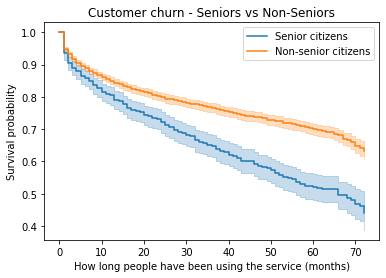

In [198]:
senior = df_train["SeniorCitizen_1"] == 1

ax = plt.subplot(111)
plt.title('Customer churn - Seniors vs Non-Seniors')
kmf.fit(T[senior], C[senior], label="Senior citizens")
kmf.plot(ax=ax)

kmf.fit(T[~senior], C[~senior], label="Non-senior citizens")
kmf.plot(ax=ax)


plt.xlabel('How long people have been using the service (months)');
plt.ylabel('Survival probability');

Here we can see that senior citizens have a higher probability of churning.

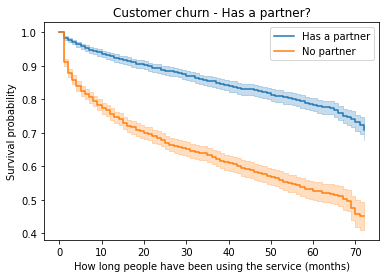

In [199]:
partner = df_train["Partner_Yes"] == 1

ax = plt.subplot(111)
plt.title('Customer churn - Has a partner?')
kmf.fit(T[partner], C[partner], label="Has a partner")
kmf.plot(ax=ax)

kmf.fit(T[~partner], C[~partner], label="No partner")
kmf.plot(ax=ax)


plt.xlabel('How long people have been using the service (months)')
plt.ylabel('Survival probability');

Having a partner seems to make people more likely to stay with the service, probably due to a certain bundle they can obtain as a couple.

So far we looked at only how tenure and the observed event(`churn` in our case) can help us make inferences about different groups. Next we'll use the other features to build the survival function. We will use **Cox proportional-hazards model** . 

### Survival regression

With the Cox proportional-hazards model we can we regress the other features against `tenure` and, just like in a linear regression, obtain coefficients for each feature about its impact on the target.

In [200]:
from lifelines import CoxPHFitter

cph = CoxPHFitter(penalizer=0.1)
cph.fit(df_train, duration_col='tenure', event_col='Churn');

After fitting the model, we can look at the coefficients for each feature. The coefficients tell us how much each feature influences a customer into churning.

In [201]:
cph_coef = pd.DataFrame(cph.params_).sort_values(by="coef", ascending=False)
cph_coef

,coef
covariate,
Contract_Month-to-month,0.835904
OnlineSecurity_No,0.306870
OnlineBackup_No,0.289447
PaymentMethod_Electronic check,0.255257
TechSupport_No,0.227673
DeviceProtection_No,0.177539
MultipleLines_No,0.175703
InternetService_Fiber optic,0.175155
PaperlessBilling_Yes,0.166904


From the table, we can, for example, deduce that having a *month-to-month contract* (positive coef) will make a customer more likely to churn than having a *two-year contract* (negative coef) or a *one year contract*(negative coef).

Another example, just like we've seen when ploting the Kaplan Meier curve, having a partner(`Partner_Yes`) makes one less likely to churn (neg coef: -0.43).

### Customer tenure prediction

We can use the Cox proportional-hazards model to predict how long the customers will stay given the features.
First, we can predict the tenure assuming the customers have just joined.

In [202]:
pred = pd.DataFrame(cph.predict_expectation(df_test), columns=['tenure - today'])
pred

,tenure - today
1830,66.999107
2304,66.023938
5114,40.670139
5842,46.269743
5040,54.037722
...,...
1297,18.937876
5524,68.979200
3060,61.703088
5942,37.124308


But, more importantly, we want to take into account the fact that the customers have stayed with the service for a certain amount of time. This only makes sense for the customers who haven't yet churned. For that we can use a *conditional argument* in the function call.

In [203]:
pred_cond = pd.DataFrame(cph.predict_expectation(df_test, conditional_after=df_test["tenure"]), columns=["conditional tenure"])
pred_cond

,conditional tenure
1830,63.348222
2304,63.281533
5114,23.317033
5842,43.974393
5040,48.751774
...,...
1297,22.684215
5524,66.010552
3060,56.662301
5942,37.391752


Side by side comparison.

In [205]:
pd.concat([df_test['tenure'], df_test['Churn'], pred, pred_cond], axis=1)

,tenure,Churn,tenure - today,conditional tenure
1830,32.0,0.0,66.999107,63.348222
2304,67.0,0.0,66.023938,63.281533
5114,50.0,0.0,40.670139,23.317033
5842,13.0,0.0,46.269743,43.974393
5040,20.0,0.0,54.037722,48.751774
...,...,...,...,...
1297,5.0,0.0,18.937876,22.684215
5524,45.0,0.0,68.979200,66.010552
3060,25.0,0.0,61.703088,56.662301
5942,9.0,1.0,37.124308,37.391752


We observe some interesting results. For example, for the customer from row 3, we see that by not taking into account `tenure`, the model predicts 40 months, while the conditional model, which does take `tenure` into account (50 months in this case), predicts a lower duration - 23 months.

Individual customers with the same tenure can also be analyzed and see what their survival probability is.

In [206]:
not_churned = df_train.query("Churn == 0")

In [207]:
not_churned.query('tenure == 30').head() #sample some individual with the same tenure

,tenure,Churn,MonthlyCharges,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Partner_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,...,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,Dependents_Yes,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes
514,30.0,0.0,1.006127,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
5067,30.0,0.0,0.052800,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2764,30.0,0.0,0.095982,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
593,30.0,0.0,0.650705,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
929,30.0,0.0,0.722122,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0


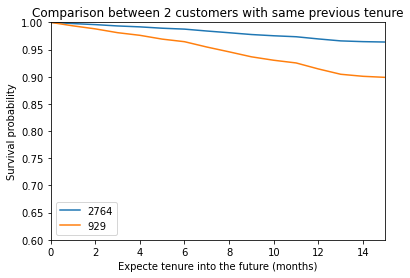

In [208]:
ax = plt.subplot(111)
cph.predict_survival_function(not_churned.loc[2764,:], conditional_after=not_churned.loc[2764,:]["tenure"]).plot(ax=ax);
cph.predict_survival_function(not_churned.loc[929,:], conditional_after=not_churned.loc[929,:]["tenure"]).plot(ax=ax);
plt.title('Comparison between 2 customers with same previous tenure')
plt.xlabel('Expecte tenure into the future (months)')
plt.ylabel('Survival probability')
plt.ylim([0.6,1]);
plt.xlim([0,15]);

Based on their individual slopes, we see that the survival probability is less for the customer `929`, so we might, for instance, target them more in an email campaign.

### Model accuracy

But how good is our model?

In order to answer this, we can look at the concordance index which is used for validating the predictive ability of a survival model. It's based on the idea of correctly ranking pairs given their survival probability - if ranked correctly we say they are concordant.

In [209]:
cph.score(df_test, scoring_method="concordance_index")

0.8595187760879038

### Conclusion

We got 86% accuracy. A score of 1 means the pairs are perfectly concordant and a score of 0.5 - the model is not better than random. This is a good result given that our model is a simple linear model. Other techniques exist that take into account non-linearity, such as survival forests.

An interesting observation we got from the features importance is how the type of contract influences the customer churning. We saw how a two-year contract or a one-year contract makes customers less likely to churn compared to one-month contracts. This makes intuitive sense and we see incentives to join a longer subscription plan everywhere on the internet these days.